# Case 2.
Lauri Marjanen, Jesse Jyrälä Team 10<br>
Neural Networks for Machine Learning Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

In [228]:
import copy
%pylab inline
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("tensorflow", tf.__version__)

Populating the interactive namespace from numpy and matplotlib
tensorflow 2.7.0


C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Background

The aim of this Notebook is to learn about concolutional2d neural networks. We wanted to understand basic functionalitys and capabilitys of Conv2d networks and after that we learned how to use pretrained models from keras.applications to make our training easier.

# Data

Different data processing methods attempted:
set image color = grayscale to change image dim from 128*128*3 to 128*128*1, did not help accuracy

In [229]:
batch_size = 128
img_height = 128
img_width = 128

curDir = os.getcwd()
train_dir = curDir + '/input/train' # we merged all datasets into one folder

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.3,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)


# Validation dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.3,
  subset = "validation", # Only used for testing
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)


Found 5216 files belonging to 2 classes.
Using 3652 files for training.
Found 5216 files belonging to 2 classes.
Using 1564 files for validation.


First we started out using a classic model with no modifications to data which which yielded excellent results, then we wanted to try out augmenting the data. For this case light augmentation seemed like a good idea as chest xrays are very similar to each other. augmenting the data increased the test accuracy results slightly. 

In [230]:
datagen = ImageDataGenerator( # Usually xray machines force you to stand still in a specific position,
                              # so it does not make sense for the data to be augmented too much
  width_shift_range=0.01,
  height_shift_range=0.01,
  shear_range=0.01,
  zoom_range=0.01,
  fill_mode='nearest',
)
train_gen_ds = datagen.flow_from_directory(train_dir, class_mode='binary',
                                         target_size = (img_height, img_width),
                                         batch_size = batch_size)

Found 5216 images belonging to 2 classes.


In [231]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Model and training

We made 4 different models. First is model that is just simple conv2d network without further datamanipulation or augmentation, second is gen_model that is the same model but has data augmentation before the model, third is pre_model that has a pretrained transfermodel without data augmentation and lastly pre_gen_model that has pretrained transfer model and data augmentation.

Basic conv2d model consist of three layers of conv2d and maxpooling2d followed by flatten, dense layer and sigmoid output layer. We tried alot of different variations with layers but found out simple model with just con2d and maxpooling to work best. We also needed to flatten before the last dense layer.

In [232]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,3, padding='same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,3, padding='same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64,3, padding='same', activation= 'relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate= 1e-4),
              metrics= ['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_1073 (Conv2D)        (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_1074 (Conv2D)        (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_1075 (Conv2D)        (None, 32, 32, 64)      

In [233]:
gen_model = keras.models.clone_model(model)
gen_model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate= 1e-4),
              metrics= ['accuracy'])
gen_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_1073 (Conv2D)        (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_1074 (Conv2D)        (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_1075 (Conv2D)        (None, 32, 32, 64)      

We tried to find pretrained model that worked best with our usecase. With first a google search what are the best pretrained models for our case we got a list of ones that are commonly used. We started testing the ones on that list to find out what is the best model for us. With all we used Imagenet as weights and had a very simple and few layer child model. First we tried some from the resnet family. ResNet50 and ResNet101 gave us similiar results but ResNet50 was alot faster. After that we tried VGG16 and VGG19. Those models werent too good for our case and gave us worst results compared to ResNets and also took little longer. They also require more memory and are alot bigger sized models. Lastly we tried Inception family models. ResNet50 seemed to work best for our model. Running augmented data with pretrained model does not seem to produce good results.

In [234]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model = tf.keras.applications.ResNet50(input_shape=(img_width,img_height,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
#Modeling the child

inputs = tf.keras.Input(shape = (img_width, img_height,3))
holder = preprocess_input(inputs)
holder = base_model(holder, training = False)
holder = global_average_layer(holder)
holder = tf.keras.layers.Dropout(0.2)(holder)
outputs = prediction_layer(holder)
pre_model = tf.keras.Model(inputs, outputs)

pre_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])


pre_model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_15  (None, 128, 128, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_15 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_20  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [235]:
pre_gen_model = keras.models.clone_model(pre_model)
pre_gen_model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate= 1e-4),
              metrics= ['accuracy'])

pre_gen_model.summary()

C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_15  (None, 128, 128, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_15 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_20  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [236]:
import time
EPOCHS = 4
VERBOSE = 0

In [237]:
t0 = time.time()

hist = model.fit(
  train_ds,
  #validation_data= val_ds,
  verbose = VERBOSE,
  epochs = EPOCHS,
)

print("First model training time:",time.time() - t0) # around 25 secs per epoch

First model training time: 94.53462815284729


In [238]:
t0 = time.time()

gen_hist = gen_model.fit(
  train_gen_ds,
  #validation_data= val_gen_ds,
  verbose = VERBOSE,
  epochs = round(EPOCHS),
)
print("Second model training time:",time.time() - t0) # around 125 secs per epoch

Second model training time: 504.2673280239105


In [239]:
t0 = time.time()

pre_hist = pre_model.fit(
  train_ds,
  #validation_data= val_ds,
  verbose = VERBOSE,
  epochs = round(EPOCHS),
)
print("Third model training time:",time.time() - t0) # around 60 secs per epoch

Third model training time: 228.90503478050232


In [240]:
t0 = time.time()

pre_gen_hist = pre_gen_model.fit(
  train_gen_ds,
  #validation_data= val_gen_ds,
  verbose = VERBOSE,
  epochs = round(EPOCHS),
)
print("Fourth model training time:",time.time() - t0) # around 106 secs per epoch

Fourth model training time: 736.1746017932892


# Results and Discussion

Here we look at the results.

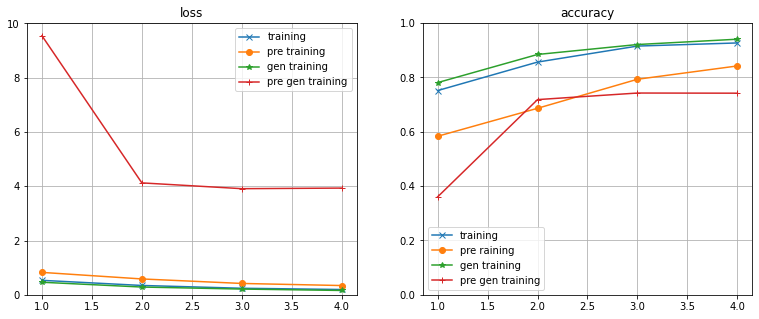

In [241]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure, subplot, plot, title, ylim, legend, grid

x_axis = np.arange(len(hist.history['loss'])) + 1


figure(figsize(13,5))
subplot(1,2,1)
plot(x_axis, hist.history['loss'], 'x-', label = 'training')
plot(x_axis, pre_hist.history['loss'], 'o-', label = 'pre training')
plot(x_axis, gen_hist.history['loss'], '*-', label = 'gen training')
plot(x_axis, pre_gen_hist.history['loss'], '+-', label = 'pre gen training')

title('loss')
ylim(0,)
legend()
grid()


subplot(1,2,2)
plot(x_axis, hist.history['accuracy'], 'x-', label = 'training')
plot(x_axis, pre_hist.history['accuracy'], 'o-', label = 'pre raining')
plot(x_axis, gen_hist.history['accuracy'], '*-', label = 'gen training')
plot(x_axis, pre_gen_hist.history['accuracy'], '+-', label = 'pre gen training')

title('accuracy')
ylim(0,1.0)
legend()
grid()

In [ ]:
#WORK IN PROGRESS CONFUSION MATRIX

#Ongelmana on ku n me ei käytetä suoraan sitä label jakamista nii ne labelit pitää käsin ottaa sieltä test setistä ulos enkä saa noita kaikkia batcheja suoraan listana ulos oikein millään. En oo myöskään varma menikö toi pred datan haku oikein.

from sklearn.metrics import confusion_matrix

labelsList = list()

# print(len(test_dataset))

for labels in test_dataset.take(len(test_dataset)):
    x = labels[1].numpy().tolist()
    labelsList.append(list(x))
#     print(labels[1])

print(labelsList)

final = list()
for batch in labelList:
    final.append(batch)
# print(pred)

cm = confusion_matrix(final, pred)

In [ ]:
pred = model.predict(test_dataset)
pred = (pred > 0.5)

In [242]:
results = model.evaluate(test_ds,verbose=VERBOSE)
print("Model 1 test acc:", 100 * results[1])

results = gen_model.evaluate(test_ds,verbose=VERBOSE)
print("Model 2 test acc:", 100 * results[1])

results = pre_model.evaluate(test_ds,verbose=VERBOSE)
print("Model 3 test acc:", 100 * results[1])

results = pre_gen_model.evaluate(test_ds,verbose=VERBOSE)
print("Model 4 test acc:", 100 * results[1])

Model 1 test acc: 94.62915658950806
Model 2 test acc: 95.78005075454712
Model 3 test acc: 92.45524406433105
Model 4 test acc: 75.63938498497009


# Conclusions

From our 4 models we can say a simple conv2d network seems to work best for our usecase. That is propably due to the very refined and simple nature of the data that we are analaysing in this case. The format of chest Xray is very standard so there isnt much other difference in the pictures than the actual desease we want to find from the pictures. That is propably why using the pretrained models actually seem to have weaker results since they are propably been made with alot more complicated data and might indruduce problem from that.

Even tho the data is very clean and comes from standard format the small augmentation of the data prepares the model for small changes in the picture like size of the torso, small rotation of torso, how zoomed in teh picture was taken and so on. 

Problems we had:
1. Amount of loss might be too high. We didn't find ways to make it go down from approximately 10%.
2. For some reason adding validation data didn't seem to help much, and in some runs even made worse the results for test data.
3. Using data augmentation with transfer models completely ruined the result.